In [12]:
import sys
sys.path.append('../src')
import random

from fats.create_pyg_dataset_mp import TransitionStateGraphDataset
from fats.graph_tools import graph_plotter, convert_gpytorch_to_networkx
ASE_DB_PATH = "../data/ts.db"
GRAPH_DATASET_PATH = "../data"
STRUCTURE_DICT = {"tolerance": 0.5, "scaling_factor": 1.5, "second_order_nn": False}
FEATURES_DICT = {"adsorbate": False, "radical": False, "valence": False, "gcn": False, "magnetization": False}
GRAPH_PARAMS = {"structure": STRUCTURE_DICT, "features": FEATURES_DICT, "target": "scaled_energy"}

FG_dataset = TransitionStateGraphDataset(ASE_DB_PATH, GRAPH_DATASET_PATH, GRAPH_PARAMS, "calc_type=transition_state")

{(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 7): 0, (0, 10): 0, (1, 5): 0, (1, 10): 0, (1, 11): 0, (1, 12): 0, (1, 13): 0, (3, 9): 0, (4, 7): 0, (4, 10): 0, (4, 12): 0, (4, 8): 1, (5, 11): 0, (6, 8): 0, (6, 12): 0, (7, 10): 0, (8, 11): 0, (8, 12): 0, (9, 10): 0, (9, 11): 0, (9, 12): 0, (9, 13): 0, (10, 11): 0, (10, 12): 0, (10, 13): 0, (11, 12): 0, (11, 13): 0, (12, 13): 0, (1, 0): 0, (2, 0): 0, (3, 0): 0, (7, 0): 0, (10, 0): 0, (5, 1): 0, (10, 1): 0, (11, 1): 0, (12, 1): 0, (13, 1): 0, (9, 3): 0, (7, 4): 0, (10, 4): 0, (12, 4): 0, (8, 4): 1, (11, 5): 0, (8, 6): 0, (12, 6): 0, (10, 7): 0, (11, 8): 0, (12, 8): 0, (10, 9): 0, (11, 9): 0, (12, 9): 0, (13, 9): 0, (11, 10): 0, (12, 10): 0, (13, 10): 0, (12, 11): 0, (13, 11): 0, (13, 12): 0}
{(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 7): 0, (0, 10): 0, (1, 5): 0, (1, 10): 0, (1, 11): 0, (1, 12): 0, (1, 13): 0, (3, 9): 0, (4, 7): 0, (4, 10): 0, (4, 12): 0, (4, 8): 1, (5, 11): 0, (6, 8): 0, (6, 12): 0, (7, 10): 0, (8, 11): 0, (8, 12): 0, (9, 10): 0, (9, 1

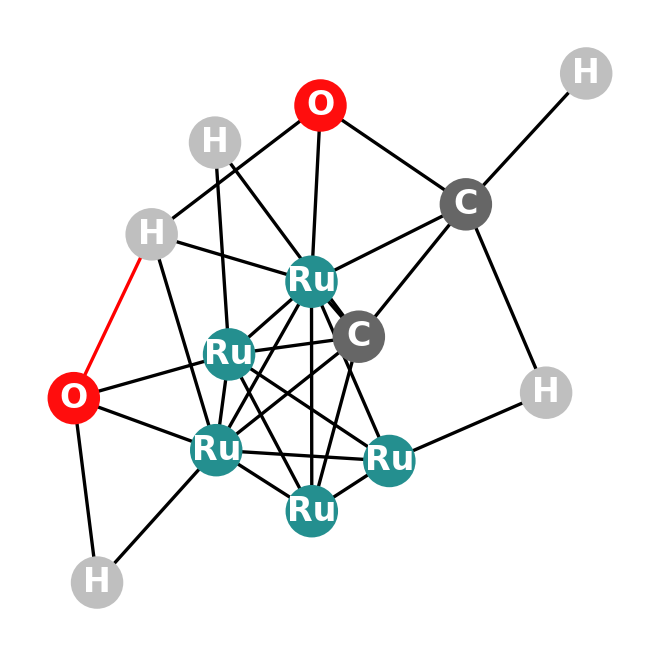

In [24]:
random_graph = random.choice(FG_dataset)
nx_graph = convert_gpytorch_to_networkx(random_graph, FG_dataset.ohe_elements)
graph_plotter(random_graph, FG_dataset.ohe_elements, node_index=False)

In [25]:
random_graph.bb_idxs

(40, 44)

In [26]:
from ase.visualize import view
view(random_graph.atoms_obj)

<Popen: returncode: None args: ['/home/smorandi/miniconda3/envs/gnn/bin/pyth...>

# Test for coordination number (CN)

In [ ]:
rand_num = random.randint(0, len(FG_dataset))
atoms = FG_dataset[rand_num].atoms_obj
print(atoms)

In [ ]:
for atom in atoms:
    print(atom.number)

In [ ]:
from gnn_eads.functions import get_voronoi_neighbourlist

In [ ]:
y = get_voronoi_neighbourlist(atoms, 0.25, 1.2, ["C", "H", "O", "N", "S"])
# Create a dictionary with the number of neighbours for each atom
neighbour_dict = {}
# Get distance matrix
#dist_matrix = atoms.get_all_distances(mic=True)
for i, atom in enumerate(atoms):
    coordination_number = 0
    neighbour_list = []
    for row in y:
        if i in row:
            other = row[0] if row[0] != i else row[1]
            if atoms[other].symbol in ["C", "H", "O", "N", "S"]:
                coordination_number += 0  # just consider the empty slab (no adsorbate)
            else:
                coordination_number += 1
                neighbour_list.append((atoms[other].symbol, other)) #, dist_matrix[i, other]))
        else:
            continue
    # number of neighbours is the count of occurrences of the atom in the neighbour list matrix
    neighbour_dict[i] = (coordination_number, atom.symbol, neighbour_list) # atom.position[2])
    # Get max coordination number
max_coordination_number = max([neighbour_dict[i][0] for i in neighbour_dict.keys()])
# Get generalized coordination number for each atom
gcn_dict = {}
#print(list(neighbour_dict.values())[0])
for atom_index in neighbour_dict.keys():
    cn_sum = 0.0
    for neighbour in neighbour_dict[atom_index][2]:
        cn_sum += neighbour_dict[neighbour[1]][0]
    gcn_dict[atom_index] = cn_sum / max_coordination_number


In [ ]:
from ase.atoms import Atoms
from gnn_eads.functions import get_voronoi_neighbourlist
def get_gcn(atoms_obj: Atoms, 
            adsorbate_elements: list[str]) -> dict[int, float]:
    """
    Given an ASE atoms object containing a slab with an adsorbate,
    returns a dictionary with the generalized coordination number (gcn) for each atom.
    gcn is defined as the sum of the coordination numbers of the neighbours divided by the maximum coordination number.

    Args:
        atoms_obj (Atoms): ASE atoms object containing a slab with an adsorbate
        adsorbate_elements (list[str]): list of symbols of the adsorbate elements

    Returns:
        dict[int, tuple]: dictionary with the generalized coordination number (gcn) and traditional cn for each atom
    """

    y = get_voronoi_neighbourlist(atoms_obj, 0.25, 1.2, adsorbate_elements)  # keep these parameters fixed
    neighbour_dict = {}
    for atom_index, atom in enumerate(atoms_obj):
        coordination_number = 0
        neighbour_list = []
        for row in y:
            if atom_index in row:
                neighbour_index = row[0] if row[0] != atom_index else row[1]
                if atoms_obj[neighbour_index].symbol in adsorbate_elements:
                    coordination_number += 0  # Consider slab only (no adsorbate)
                else:
                    coordination_number += 1
                    neighbour_list.append((atoms_obj[neighbour_index].symbol, neighbour_index, atoms_obj[neighbour_index].position[2])) 
            else:
                continue
        neighbour_dict[atom_index] = (coordination_number, atom.symbol, neighbour_list)
        # Get max coordination number
    max_coordination_number = max([neighbour_dict[i][0] for i in neighbour_dict.keys()])
    # Get generalized coordination number for each atom
    gcn_dict = {}
    for atom_index in neighbour_dict.keys():
        if atoms_obj[atom_index].symbol in adsorbate_elements:
            gcn_dict[atom_index] = (None, neighbour_dict[atom_index][0])
            continue
        cn_sum = 0.0
        for neighbour in neighbour_dict[atom_index][2]:
            cn_sum += neighbour_dict[neighbour[1]][0]
        gcn_dict[atom_index] = (cn_sum / max_coordination_number, neighbour_dict[atom_index][0])
    return gcn_dict


In [ ]:
gcn_dict = get_gcn(atoms, ["C", "H", "O", "N", "S"])
gcn_dict

In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict(gcn_dict, orient="index", columns=["gcn"])
df

In [ ]:
neighbour_dict

# Study

In [ ]:
FG_dataset.print_summary()

In [ ]:
for graph in FG_dataset:
    print(graph)
    break

In [ ]:
print(FG_dataset.data)

In [ ]:
FG_dataset.additional_data

In [ ]:
FG_dataset.one_hot_encoder_elements.categories_[0]

In [ ]:
graph_plotter(FG_dataset[12], FG_dataset.one_hot_encoder_elements, node_index=False)

In [ ]:
FG_dataset[12].df

In [ ]:
print(FG_dataset.counter_isomorphism, FG_dataset.counter_H_filter, FG_dataset.counter_C_filter, FG_dataset.counter_fragment_filter, FG_dataset.counter_adsorption_filter, len(FG_dataset), FG_dataset.database_size)
        

In [ ]:
FG_dataset.bin_unconverted_atoms_objects

In [ ]:
FG_dataset.node_dim

In [ ]:
random_graph = FG_dataset[59]
print(random_graph)

In [ ]:
random_graph.x

In [ ]:
import pprint
pprint.pprint(FG_dataset.node_feature_list)
pprint.pprint(random_graph.x[:, 2])
pprint.pprint(random_graph.x[:, 11])
pprint.pprint(random_graph.x[:, -1])

In [ ]:
import pandas as pd
random_graph = FG_dataset[3]
df = pd.DataFrame(random_graph.x.numpy())
df.columns = FG_dataset.node_feature_list
print(df)

In [ ]:
random_graph.elems

In [ ]:
print(random_graph)

In [ ]:
print(FG_dataset.node_feature_list)

In [ ]:
import random
random_int = random.randint(0, len(FG_dataset))
random_graph = FG_dataset[random_int]
random_graph.df

In [ ]:
# print ase atoms object
from ase.visualize import view
view(random_graph.atoms_obj)


In [ ]:
graph_plotter(random_graph, FG_dataset.one_hot_encoder_elements, node_index=True)

In [ ]:
df = random_graph.df
# Convert first 6 columns from one-hot encoding to one element column, and place the new column at the beginining
df["element"] = df.iloc[:, 0:6].idxmax(axis=1)
# place column at the beginning
df = df.drop(columns=df.columns[0:6])
df = df[["element"] + [col for col in df.columns if col != "element"]]
# Convert last  column from one-hot encoding to one element column, and place the new column at the end. 
df["facet"] = df.iloc[:, -1:].idxmax(axis=1)
# if element is C, H, O, N, or S, then the facet is "None"
df.loc[df["element"].isin(["C", "H", "O", "N", "S"]), "facet"] = "None"
df.drop(columns=df.columns[-1+(-1)], inplace=True)
df
# Convert Ring and Aromatic columns to boolean
df["Ring"] = df["Ring"].astype(bool)
df["Aromatic"] = df["Aromatic"].astype(bool)
df

In [ ]:
valence_vector = random_graph.x[:,-4]
concat_vector = torch.cat((random_graph.x[:,-4], random_graph.x[:,-4]), dim=0)
print(random_graph.elems, random_graph.x[:,-4])

In [ ]:
dir(FG_dataset)

In [ ]:
print(FG_dataset.dataset_id)

In [ ]:
database_size = FG_dataset.database_size
graph_dataset_size = len(FG_dataset)
bin_C_filter = FG_dataset.counter_C_filter
bin_H_filter = FG_dataset.counter_H_filter
bin_fragment_filter = FG_dataset.counter_fragment_filter
bin_adsorption_filter = FG_dataset.counter_adsorption_filter
bin_isomorphism = FG_dataset.counter_isomorphism

print("ASE database size: ", database_size)
print("Graph dataset size: ", graph_dataset_size)
print("C filter: ", bin_C_filter)
print("H filter: ", bin_H_filter)
print("Fragment filter: ", bin_fragment_filter)
print("Adsorption filter: ", bin_adsorption_filter)
print("Isomorphism: ", bin_isomorphism)


# Representation study

In [ ]:
adsorbate_nodes = 0
catalyst_nodes = 0
for graph in FG_dataset:
    for node in graph.x:
        if node[-1] == 1:
            adsorbate_nodes += 1
        elif node[-1] == 0:
            catalyst_nodes += 1
        else:
            raise ValueError("Node type not recognized")
print("Adsorbate nodes: ", adsorbate_nodes)
print("Catalyst nodes: ", catalyst_nodes)

In [ ]:
facet_111 = 0
facet_0001 = 0
facet_110 = 0

for graph in FG_dataset:
    if graph.facet == "fcc(111)":
        facet_111 += 1
    elif graph.facet == "hcp(0001)":
        facet_0001 += 1
    elif graph.facet == "bcc(110)":
        facet_110 += 1
    else:
        raise ValueError("Facet not recognized")
print("Facet 111: ", facet_111)
print("Facet 0001: ", facet_0001)
print("Facet 110: ", facet_110)

In [ ]:
# get distribution of metals
metals = []
for graph in FG_dataset:
    metals.append(graph.metal)

#create dictionary of metals and their counts
metal_dict = {}
for metal in metals:
    if metal not in metal_dict:
        metal_dict[metal] = 1
    else:
        metal_dict[metal] += 1
# generate boxplot of metals
import matplotlib.pyplot as plt

plt.bar(metal_dict.keys(), metal_dict.values())